In [ ]:
# Downloading and extracting the image segmentation dataset from the URL

In [1]:
import tensorflow as tf
import keras
import numpy as np
import os

In [ ]:
import urllib.request

url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
filename = "images.tar.gz"

urllib.request.urlretrieve(url, filename)

In [ ]:
url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
filename = "annotations.tar.gz"

urllib.request.urlretrieve(url, filename)

In [ ]:
# Exporting the tar files to the Image segment folder

In [ ]:
import tarfile

# Specify the filename of the tar file
filename1 = "images.tar.gz"
filename2 = "annotations.tar.gz"
extract_folder = "Image Segement Dataset"

if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Open the tar file
with tarfile.open(filename1, "r:gz") as tar:
    # Extract all contents to the current directory
    tar.extractall(path=extract_folder)

with tarfile.open(filename2, "r:gz") as tar:
    # Extract all contents to the current directory
    tar.extractall(path=extract_folder)

In [2]:
# Setting the paths for input inmages and masked images
# since \n , \t are used for literals so \\ used for representing a single backslash character
# "Image Segement Dataset\\images" will be read as Image Segement Dataset\images

input_dir = "Image Segement Dataset\\images"
target_dir = "Image Segement Dataset\\annotations\\trimaps"

input_img_paths = sorted(
    [os.path.join(input_dir,fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")]
)

target_paths = sorted(
    [os.path.join(target_dir,fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")]
)

In [3]:
input_img_paths[0]

'Image Segement Dataset\\images\\Abyssinian_1.jpg'

(-0.5, 499.5, 447.5, -0.5)

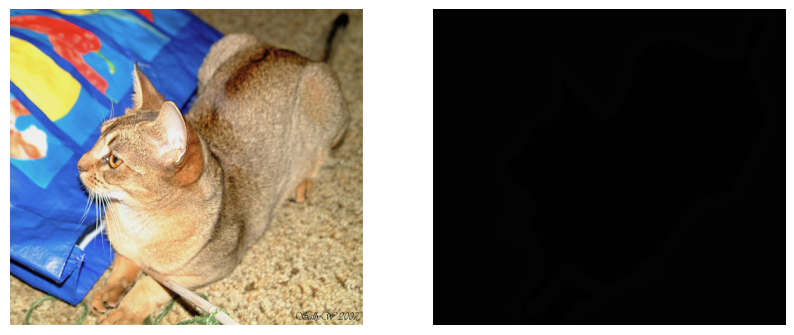

In [4]:
# Viewing the images ( Image vs Marked images or target image)
import matplotlib.pyplot as plt

from keras.utils import load_img, img_to_array # Used for loading images and converting them to arrays

# Load the first image
img1 = load_img(input_img_paths[9])

# Load the second image
img2 = load_img(target_paths[9])

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')

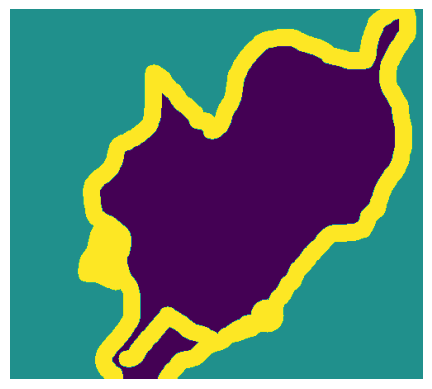

In [5]:
# To display the target in a better way

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127 # Original labels are 1,2,3 : we are subtracting 1 to range it between 0 and 2 , then multipying by 127 so that we can view the data more brightly
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [6]:
# Distributing the inputs and targets into train and validation datasets

import random

img_size = (200,200) # Used to reshape every image to a consistent size
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths) # 1337 is a seed values chosen at random, but we need to give the same values to both image and target , so that the shuffling is similar for both the folders
random.Random(1337).shuffle(target_paths)

# Function for loading the input images using the path and resizing them to (200,200) and converting them into arrays
def path_to_input_image(path):
    return img_to_array(load_img(path,target_size=img_size))

# Function for loading the target images using the path and resizing them to (200,200) and converting them into arrays , changing the labels range from 1,3 to 0,2 and color mode to greyscale
def path_to_target(path):
    img = img_to_array(load_img(path,target_size=img_size,color_mode="grayscale"))
    img = img.astype("uint8") - 1   # For bringing the labels range to 0,2
    return img

# The arrays are initialized here using np.zeros
# Loading all input images to float32 array , with channels = 3 for RGB 
input_imgs = np.zeros((num_imgs,) + img_size + (3,) , dtype="float32")  # Shape will be (num of images,200,200,3)
#Loading all targets to uint8 array, with channel = 1 for grreyscale 
targets = np.zeros((num_imgs,) + img_size + (1,) , dtype="uint8") # Shape will be (num of targets,200,200,1) # If we dont include the comma at end of each tuple, it will not concatenate them

# The initialized arrays are then filled with values using the functions mentioned above while converting the images into arrays
# We wanted a tensor with shape (num of images,200,200,3 or 1), so we first converted the images to arrays then filling them in these tensors
for i in range(num_imgs): 
    input_imgs[i] = path_to_input_image(input_img_paths[i]) 
    targets[i] = path_to_target(target_paths[i])

In [7]:
# input_imgs and targets are 2 tensors for shape (num of images,200,200,3) and (num of targets,200,200,1)
print(input_imgs.shape)
print(targets.shape)

(7390, 200, 200, 3)
(7390, 200, 200, 1)


In [8]:
# Validation and Train datasets created
num_valdiation_samples = 1000

train_input_images = input_imgs[num_valdiation_samples:]
train_target_images = targets[num_valdiation_samples:]

validation_input_images = input_imgs[:num_valdiation_samples]
validation_target_images = input_imgs[:num_valdiation_samples]

In [9]:
# Model build
from keras.layers import Conv2D,Conv2DTranspose,Rescaling,Input
from keras.models import Model

In [10]:
def get_model(img_size,num_classes):
# Input layer
    input_layer = Input(shape=img_size + (3,))
    rescale_layer = Rescaling(1./255)(input_layer) # rescaling of inputs

# Convolutional layers : Purpose of these layers is to compress the image arrays 
    conv_layer1 = Conv2D(64,3,activation="relu",padding="same",strides=2)(rescale_layer) # Padding kept as same for each layer since we want to avoid influence of border padding on feature map size
    conv_layer2 = Conv2D(64,3,activation="relu",padding="same")(conv_layer1) # 64 represents the number of kernels and 3 represents the kernel size
    conv_layer3 = Conv2D(128,3,activation="relu",padding="same",strides=2)(conv_layer2)
    conv_layer4 = Conv2D(128,3,activation="relu",padding="same")(conv_layer3)
    conv_layer5 = Conv2D(256,3,activation="relu",padding="same",strides=2)(conv_layer4)
    conv_layer6 = Conv2D(256,3,activation="relu",padding="same")(conv_layer5)

# Convolutional Transpose layers :
    conv_tran_layer1 = Conv2DTranspose(256,3,activation="relu",padding="same")(conv_layer6)
    conv_tran_layer2 = Conv2DTranspose(256,3,activation="relu",padding="same",strides=2)(conv_tran_layer1)
    conv_tran_layer3 = Conv2DTranspose(128,3,activation="relu",padding="same")(conv_tran_layer2)
    conv_tran_layer4 = Conv2DTranspose(128,3,activation="relu",padding="same",strides=2)(conv_tran_layer3)
    conv_tran_layer5 = Conv2DTranspose(64,3,activation="relu",padding="same")(conv_tran_layer4)
    conv_tran_layer6 = Conv2DTranspose(64,3,activation="relu",padding="same",strides=2)(conv_tran_layer5)

# Output layer
    output_layer = Conv2D(num_classes,3,activation="softmax",padding="same")(conv_tran_layer6)

    model = Model(input_layer,output_layer)

    return model

# We are using strides instead of max pooling for downsampling our images, because we care a lot about spatial location of information in the images, and max pooling destroys the location information,
# so we are using strides insted of max pooling here ( Strides preferred when location of an object in the image / location information is very important for the task)


In [11]:
model = get_model(img_size,3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [12]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="rmsprop",metrics="accuracy") # Sparse categorical cross entropy since each pixel has an integer class from range 0,2 i.e integer

In [13]:
from keras.callbacks import ModelCheckpoint

In [17]:
callbacks_list = [ModelCheckpoint(filepath="Image Segmentation.keras",save_best_only=True,monitor="val_loss")]

In [15]:
history = model.fit(train_input_images,train_target_images,epochs=5,callbacks=callbacks_list,validation_data=(validation_input_images,validation_target_images),batch_size=1)
history

Epoch 1/5
6390/6390 [==============================] - ETA: 0s - loss: 0.7699 - accuracy: 0.6984

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [16]:
# Reduced the batch size to 1 , due to out of memory issue(also reduced the epochs to 5 to reduce training time)
# Still getting the error because the GPU is unable to handle the batch size even when set to 1, so cant train the model

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
# Plotting loss and metrics

num_epochs = range(1, len(history_dict["loss"])+1)

plt.plot(num_epochs, history_dict["loss"], label="Training loss")
plt.plot(num_epochs, history_dict["val_loss"], label="Validation loss")

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation losses")
plt.title("Loss Curve over Epochs")
plt.show()

In [ ]:
num_epochs = range(1, len(history_dict["loss"])+1)

plt.plot(num_epochs, history_dict["accuracy"], label="Training Accuracy")
plt.plot(num_epochs, history_dict["val_accuracy"], label="Validation Accuracy")

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation Accuracy")
plt.title("Accuracy Curve over Epochs")
plt.show()